In [45]:
import math
import numpy as np
import pandas as pd
import datetime as dt
from pytrends import dailydata
from pytrends.request import TrendReq
from sklearn.preprocessing import MinMaxScaler

# Each term individually
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Set Styling
from simple_colors import *
sns.set_style('dark')
sns.set_palette('RdBu')

#  Search Term Data
Originally, we planned on using a wide variety of search terms other than just "depression" and "anxiety," so you see in this notebook we collected search term data from other terms as well. In the end though, only depression and anxiety scores were used for our research.

In [2]:
negative_mental_health_keywords = ["anxiety", "depression", "OCD", "hopeless", "angry", "afraid", 
                                   "apathy", "worthless", "worried", "restless", "irritable", 
                                   "tense", "scattered", "tired", "avoiding", "procrastinate", 
                                   "insomnia", "suicidal", "suicide" ]

## Demonstrate how normalization across time works

In [26]:
batch_df = daily_search_term_freq(start_date='2017-01-01', end_date='2017-04-01', kw_list=['anxiety'])

In [27]:
batch_df.reset_index(level=0).drop(columns='isPartial').tail()

,date,anxiety
86,2017-03-28,97
87,2017-03-29,92
88,2017-03-30,92
89,2017-03-31,85
90,2017-04-01,76


In [28]:
batch_df = daily_search_term_freq(start_date='2017-04-01', end_date='2017-06-30', kw_list=['anxiety'])

In [29]:
batch_df.reset_index(level=0).drop(columns='isPartial').head()

,date,anxiety
0,2017-04-01,74
1,2017-04-02,80
2,2017-04-03,93
3,2017-04-04,93
4,2017-04-05,86


In [30]:
batch_df = daily_search_term_freq(start_date='2017-01-01', end_date='2017-06-30', kw_list=['anxiety'])

In [35]:
batch_df.reset_index(level=0).iloc[90 - 4: 90 + 4]

,date,anxiety
86,2017-03-28,97
87,2017-03-29,92
88,2017-03-30,92
89,2017-03-31,85
90,2017-04-01,76
91,2017-04-02,82.1622
92,2017-04-03,95.5135
93,2017-04-04,95.5135


In [4]:
def daily_search_term_freq(start_date: str, end_date: str, kw_list: list) -> pd.DataFrame:
    
    """
    Google Trends can only compare search term frequency for 90 days of data. If attempting to compare
    term frequency across more than 90d, Google will instead send data back on a weekly basis.
    
    This script circumvents this quirk of the Google Trends API and collects search term frequency data 
    accross a time frame longer than 90d. It normalizes the data such that search term frequency for each
    term is a RELATIVE score representing a term's frequency, in comparison to OTHER TERMS across the 
    ENTIRE TIME FRAME
    
    * Code adapted from Github user maliky's solution found here: https://github.com/GeneralMills/pytrends/issues/174
    
    :param: start_date: a date string in the form of 'YYYY-MM-DD' representing the first date to pull data from
    :param: end_date: a date string in the form of 'YYYY-MM-DD' representing the last date to pull data from
    :param: kw_list: a list of keywords (5 max)
    
    :returns: a dataframe representing the relative search term frequencies of each word in kw_list, where 
              one row represents one day of search data
    """


    #### connect to google
    pytrends = TrendReq(hl='en-US', tz=360)
    #### build the playload
    cat = 0
    geo = ''
    gprop = '' 
    # dates can be formated as  `2017-12-07 2018-01-07`, or  `today 3-m` `today 5-y`  check trends.google.com's url
    date_fmt = '%Y-%m-%d'
    start_date, end_date = map(lambda x : dt.datetime.strptime(x, date_fmt)
                               , [start_date, end_date])

    ### Building an array of 90d periods to retreive google trend data with a one day resolution
    ninety_day_periods = math.ceil( (end_date - start_date) / dt.timedelta(days=90) ) 

    # _tmp_range is a list of dates separated by 90d.  We need one more than the number of _90_periods.  if _end_date is in the future google returns the most recent data
    tmp_range = pd.date_range(start= start_date, periods= ninety_day_periods + 1, freq= '90D')

    # making the list of `_start_date _end_date`, strf separated by a space
    rolling_dates = [ ' '.join(map(lambda x : x.strftime(date_fmt)
                                    , [tmp_range[i], tmp_range[i+1] ])
                                )
                        for i in range(len(tmp_range)-1) ]

    # initialization of the major data frame _df_trends
    # _dates will contains our last playload argument
    dates = rolling_dates[0]
    pytrends.build_payload(kw_list, cat=cat, timeframe=dates, geo=geo, gprop=gprop)
    df_trends= pytrends.interest_over_time()

    for dates in rolling_dates[1:] :
        # we need to normalize data before concatanation
        common_date = dates.split(' ')[0]
        pytrends.build_payload(kw_list, cat=cat, timeframe=dates, geo=geo, gprop=gprop)
        tmp_df = pytrends.interest_over_time()
        multiplication_factor = df_trends.loc[common_date] / tmp_df.loc[common_date]

        df_trends= (pd.concat([df_trends,
                               (tmp_df[1:]* multiplication_factor)])
                     .drop(labels = 'isPartial', axis = 1)  # isPartial usefull ?
                     .resample('D', closed='right').bfill()  # making sure that we have one value per day. 
                    )
    
    return df_trends


# Individual Search Terms
Get Trends Data in which each search term is simply scaled from 0-100. In this case, individual search term scores cannot be compared to one another.

In [ ]:
# Sum of google trends scores for all searches in the negative mental health corpus
individual_search_term_frequencies = pd.DataFrame()

for keyword in negative_mental_health_keywords:
    
    # Get search term interest
    one_term_freq = daily_search_term_freq(start_date=start_date, end_date=end_date, kw_list=[keyword])
    
    # Add this term to the larger df
    individual_search_term_frequencies = pd.concat([individual_search_term_frequencies, one_term_freq], axis=1)

In [25]:
# Make sure that date is registered as a data attribute, not indices of the data:
individual_search_term_frequencies.reset_index(level=0, inplace=True)

individual_search_term_frequencies.tail()

,date,anxiety,depression,OCD,hopeless,angry,afraid,apathy,worthless,worried,restless,irritable,tense,scattered,tired,avoiding,procrastinate,insomnia,suicidal,suicide
1390,2020-10-22,122.742133,81.260908,78.764057,226.078404,50.019544,38.195573,60.676710,64.266640,125.169325,51.815159,88.202227,130.449756,95.978739,79.554913,36.414193,68.278407,111.045756,121.096827,38.827482
1391,2020-10-23,108.066443,73.224114,74.968199,211.172135,50.019544,38.711730,60.676710,84.040991,112.806922,50.178891,73.821429,109.633306,101.097605,71.937954,31.745707,59.402214,67.737911,135.628446,37.632790
1392,2020-10-24,98.727368,66.080298,72.121305,201.234623,51.705596,38.195573,53.675551,80.086121,84.991517,43.088396,69.986549,77.714748,80.622141,66.859980,29.411464,38.918692,66.627453,122.711451,40.022173
1393,2020-10-25,105.398136,72.331137,68.325447,213.656514,51.705596,38.711730,53.675551,71.187663,109.716322,37.634168,90.119666,74.939222,76.782991,71.091625,25.676675,40.967044,63.296081,96.877461,39.424828
1394,2020-10-26,116.071365,78.581977,76.866128,203.719001,44.961388,38.195573,72.345308,88.984579,115.897523,45.270087,80.532468,120.735412,81.901857,71.091625,31.278859,54.622726,63.296081,117.867578,40.619519


In [ ]:
individual_search_term_frequencies.to_pickle('./pickles/individual_search_term_frequencies.pkl')

In [47]:
# Explore data
individual_search_term_frequencies = pd.read_pickle('./pickles/individual_search_term_frequencies.pkl')

Individual Search Terms - Time Series


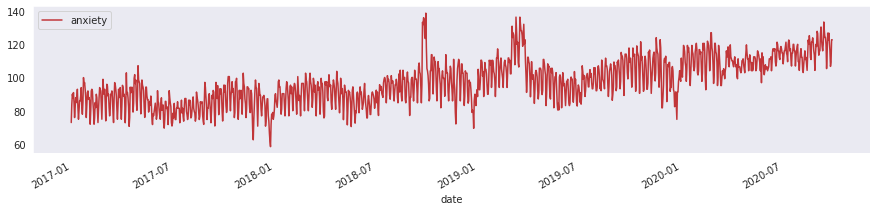

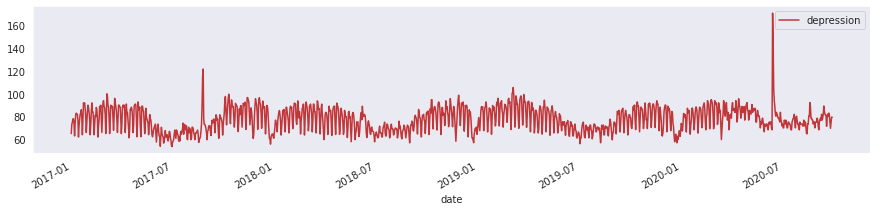

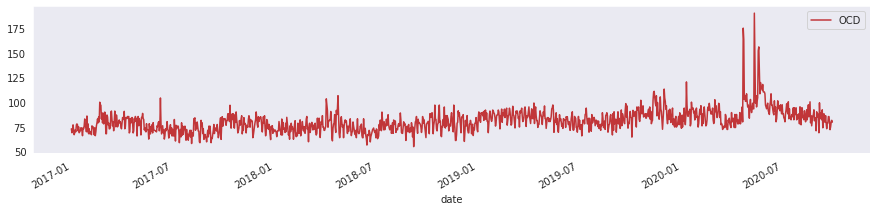

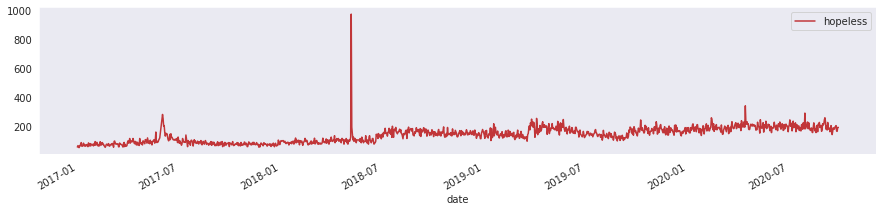

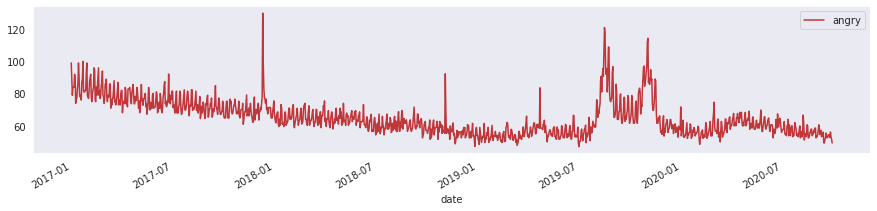

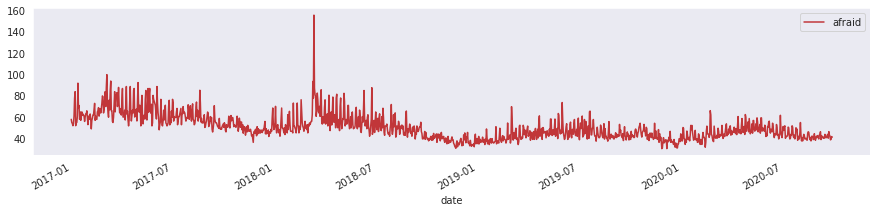

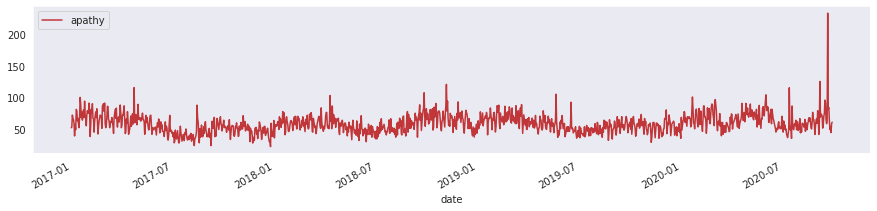

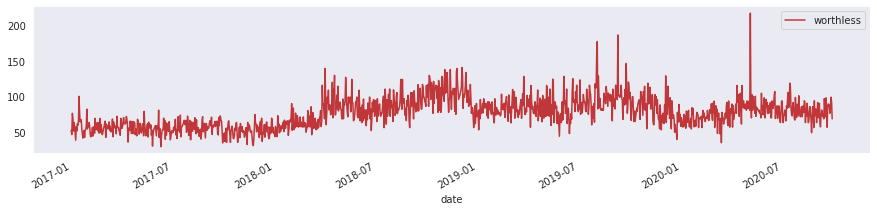

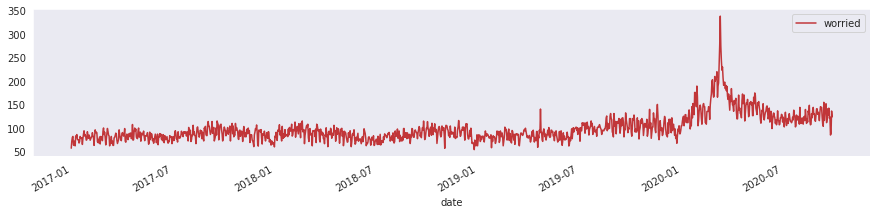

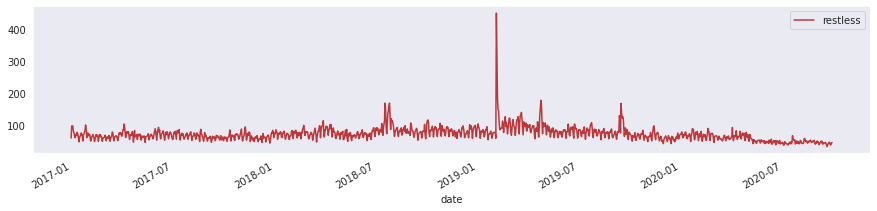

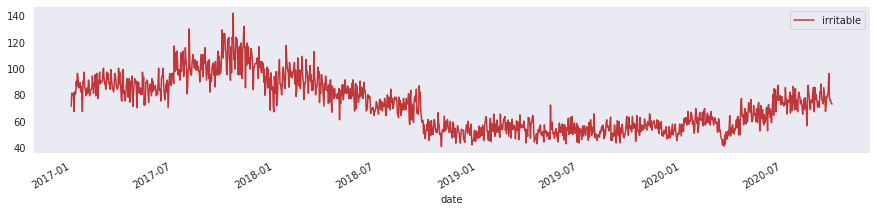

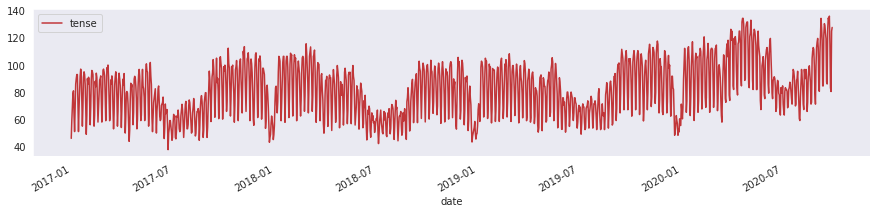

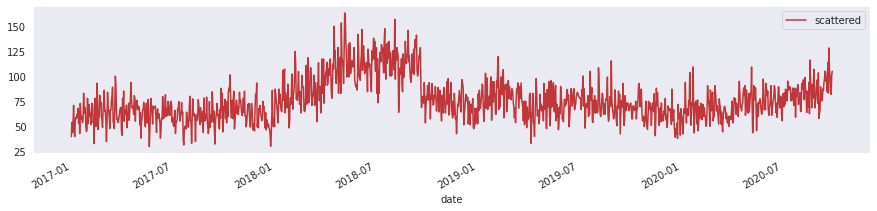

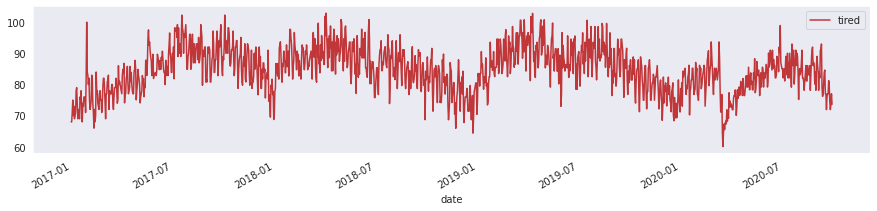

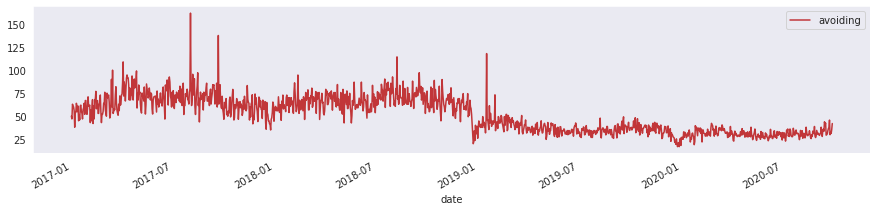

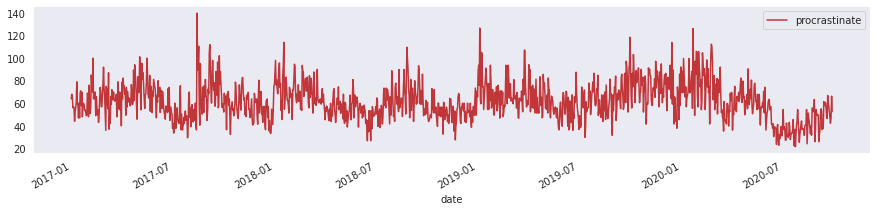

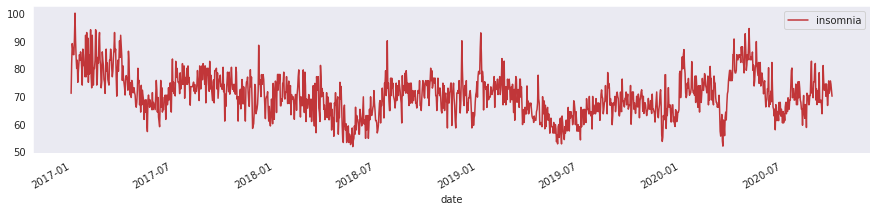

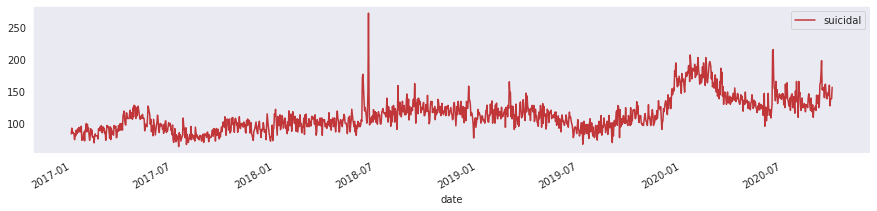

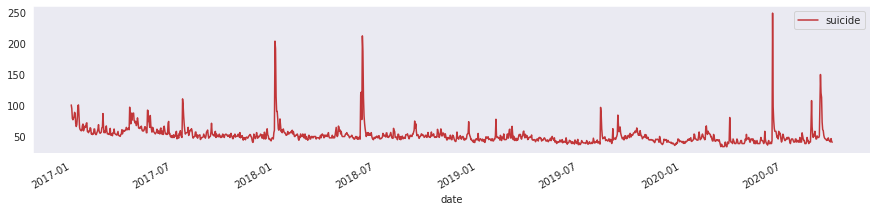

In [48]:

print('Individual Search Terms - Time Series')
for i, term in enumerate(individual_search_term_frequencies.columns):
    if term != 'date' and term != 'isPartial':
        individual_search_term_frequencies.plot.line(x='date', y=term, figsize=(15,3))
        plt.show()

In [57]:
terms_only = individual_search_term_frequencies[['depression', 'anxiety']]

Histograms for All Search Terms


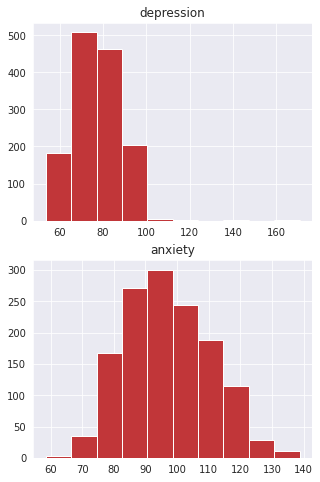

In [65]:
print('Histograms for All Search Terms')
plt.figure(figsize=(5, 8))
for n, col in enumerate(terms_only.columns):
    plt.subplot(2, 1, n+1)
    plt.title(col)
    terms_only[col].hist(ax = plt.gca())